In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### READ DATA ###

df = pd.read_csv('bbc-text.csv')

print(df.shape)
df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


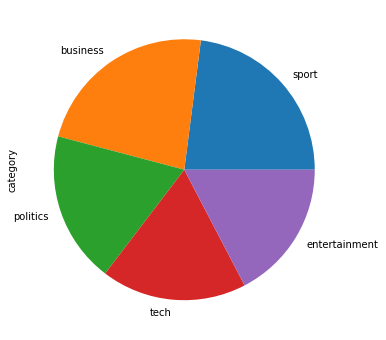

In [4]:
### LABEL DISTRIBUTION ###

df.category.value_counts().plot.pie(figsize=(6,6))

In [5]:
### SIMPLE CLEAN OF TEXT ###

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

In [6]:
### SPLIT INTO TRAIN/TEST ###

y = to_categorical(df.category.factorize()[0])

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=33, test_size=0.2)

In [7]:
### MAP LABEL ###

diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [8]:
### TRAIN WORD2VEC AND FASTTEXT ###

w2v = Word2Vec(size=100, window=5, min_count=4, seed=33)
w2v.build_vocab(X_train)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=10)

ft = FastText(size=100, window=5, min_count=4, seed=33)
ft.build_vocab(X_train)
ft.train(X_train, total_examples=ft.corpus_count, epochs=10)

In [9]:
### TRANSFORM ORIGINAL TEXT INTO SEQUENCES AND COMPUTE PADDING ###

max_len = 200

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(1780, 200) (445, 200)


In [10]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM WORD2VEC ###

embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 14539


In [11]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM FASTTEXT ###

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 35


In [12]:
### DEFINE INPUT LAYER FOR EMBEDDINGS READING AND CONCATENATION ###

def Concat_Emb(list_emb, maxlen):
    
    inputs = []
    output = []
    for embedding in list_emb:
        
        inp = Input(shape=(maxlen,))
        emb = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,100,1))(emb)
        inputs.append(inp)
        output.append(emb)
        
    concat = Concatenate(axis=-1)(output)
    
    return Model(inputs, concat)

In [13]:
### TRY Concat_Emb ###

read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     2537000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     2537000     input_2[0][0]                    
______________________________________________________________________________________________

In [14]:
### DEFINE DME AND CDME BLOCKS ###

def DME(maxlen):

    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, 100*2))(inp)
    x = LSTM(2, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

def CDME(maxlen, latent_dim=2):
    
    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, 100*2))(inp)
    x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x = Lambda(lambda t: [t[:,:,:int(latent_dim/2+1)], t[:,:,int(latent_dim/2+1):]])(x)
    x = Maximum()(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

In [15]:
### DEFINE NETWORK WITH DME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     2537000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     2537000     input_4[0][0]                    
____________________________________________________________________________________________

In [16]:
dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Train on 1602 samples, validate on 178 samples
Epoch 1/20
1602/1602 - 20s - loss: 1.4767 - accuracy: 0.3752 - val_loss: 1.3115 - val_accuracy: 0.4888
Epoch 2/20
1602/1602 - 15s - loss: 1.2179 - accuracy: 0.5275 - val_loss: 1.1532 - val_accuracy: 0.5787
Epoch 3/20
1602/1602 - 18s - loss: 1.0577 - accuracy: 0.5911 - val_loss: 1.1147 - val_accuracy: 0.5899
Epoch 4/20
1602/1602 - 17s - loss: 0.8979 - accuracy: 0.6629 - val_loss: 0.9498 - val_accuracy: 0.6461
Epoch 5/20
1602/1602 - 16s - loss: 0.7512 - accuracy: 0.7260 - val_loss: 0.7345 - val_accuracy: 0.7584
Epoch 6/20
1602/1602 - 17s - loss: 0.6102 - accuracy: 0.7915 - val_loss: 0.6833 - val_accuracy: 0.7865
Epoch 7/20
1602/1602 - 17s - loss: 0.5064 - accuracy: 0.8308 - val_loss: 0.8383 - val_accuracy: 0.7191
Epoch 8/20
1602/1602 - 17s - loss: 0.5136 - accuracy: 0.8227 - val_loss: 0.6044 - val_accuracy: 0.7697
Epoch 9/20
1602/1602 - 18s - loss: 0.4271 - accuracy: 0.8583 - val_loss: 0.4513 - val_accuracy: 0.8483
Epoch 10/20
1602/1602 - 17

In [17]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))

               precision    recall  f1-score   support

     business       0.91      0.98      0.94        90
entertainment       0.95      0.89      0.92        88
     politics       0.94      0.89      0.92        73
        sport       0.97      0.97      0.97       106
         tech       0.93      0.97      0.95        88

     accuracy                           0.94       445
    macro avg       0.94      0.94      0.94       445
 weighted avg       0.94      0.94      0.94       445



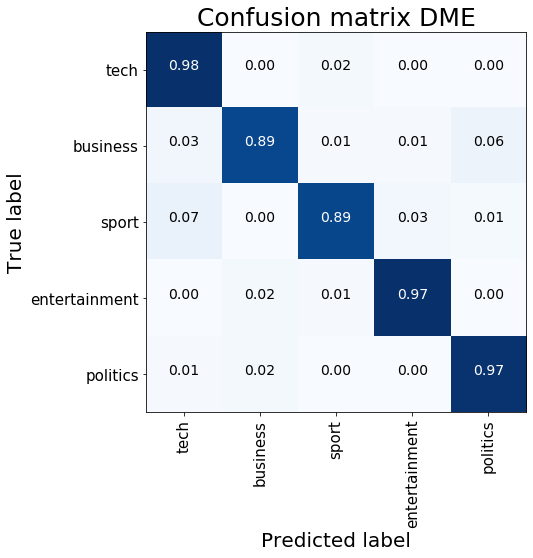

In [18]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

In [19]:
### DEFINE NETWORK WITH CDME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cdme_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 100)     2537000     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 100)     2537000     input_7[0][0]                    
____________________________________________________________________________________________

In [20]:
cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Train on 1602 samples, validate on 178 samples
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1602/1602 - 27s - loss: 1.4981 - accuracy: 0.3552 - val_loss: 1.3296 - val_accuracy: 0.4775
Epoch 2/20
1602/1602 - 18s - loss: 1.2570 - accuracy: 0.5156 - val_loss: 1.1915 - val_accuracy: 0.5449
Epoch 3/20
1602/1602 - 18s - loss: 1.0889 - accuracy: 0.5749 - val_loss: 1.1004 - val_accuracy: 0.6292
Epoch 4/20
1602/1602 - 19s - loss: 0.9181 - accuracy: 0.6442 - val_loss: 0.9757 - val_accuracy: 0.6573
Epoch 5/20
1602/1602 - 19s - loss: 0.7683 - accuracy: 0.7085 - val_loss: 0.7508 - val_accuracy: 0.7472
Epoch 6/20
1602/1602 - 20s - loss: 0.5889 - accuracy: 0.7984 - val_loss: 0.6098 - val_accuracy: 0.7865
Epoch 7/20
1602/1602 - 20s - loss: 0.5705 - accuracy: 0.8140 - val_loss: 0.8641 - val_accuracy: 0.7135
Epoch 8/20
1602/1602 - 19s - loss: 0.5719 - accuracy: 0.8027 - val_loss: 0.6690 - val_accuracy: 0.7697
Epoch 9/20
1602/1602 - 18s - loss: 

In [21]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)]))

               precision    recall  f1-score   support

     business       0.84      0.96      0.90        90
entertainment       0.90      0.86      0.88        88
     politics       0.94      0.85      0.89        73
        sport       0.96      0.98      0.97       106
         tech       0.92      0.89      0.90        88

     accuracy                           0.91       445
    macro avg       0.91      0.91      0.91       445
 weighted avg       0.91      0.91      0.91       445



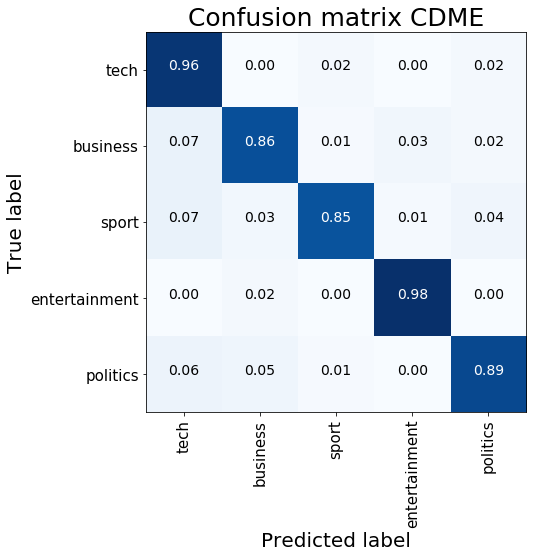

In [22]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix CDME")
plt.show()